In [46]:
from sklearn.model_selection import train_test_split
import csv

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import os



In [88]:
directory = 'data/processed'
if not os.path.exists(directory):
    os.makedirs(directory)
    
directory = 'data/fig'
if not os.path.exists(directory):
    os.makedirs(directory)

# Read data file

In [2]:
data = pd.read_csv("data/quora/quora_duplicate_questions.tsv", sep='\t')

In [3]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404290 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [5]:
data[data.isnull().any(axis=1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


In [6]:
data.dropna(inplace=True)


In [7]:
len(data)

404288

In [8]:
data['question1'] = data['question1'].apply(lambda x: (str(x)))
data['question2'] = data['question2'].apply(lambda x: (str(x)))

In [9]:
labels = np.array(data['is_duplicate'], dtype=int)


In [10]:
question1 = list(data['question1'])
question2 = list(data['question2'])

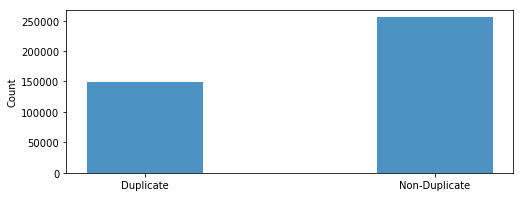

In [117]:
objects = ('Duplicate', 'Non-Duplicate')
y_pos = np.arange(len(objects))
y = [len(labels[labels==1]),len(labels[labels==0])]
fig = plt.figure(figsize=(8, 3))
plt.bar(y_pos, y, align='center', alpha=0.8,width=0.4)
plt.xticks(y_pos, objects)
plt.ylabel('Count')
# plt.title('Label count in dataset')
# plt.tight_layout()
plt.savefig('data/fig/labelcount.pdf')

# Cleaning Data (Remove question mark and punctuations)

In [13]:
import string,re
question1 = [re.sub("["+string.punctuation+"]", " ", s) for s in question1]
question2 = [re.sub("["+string.punctuation+"]", " ", s) for s in question2]

question1 = [re.sub(r'[^\x00-\x7f]',r' ',s) for s in question1]
question2 = [re.sub(r'[^\x00-\x7f]',r' ',s) for s in question2]

In [18]:
#split words 
question1_splitted = [s.split() for s in question1]
question2_splitted = [s.split() for s in question2]

In [19]:
#make all words lower case
question1_lower = [[w.lower() for w in s] for s in question1_splitted]
question2_lower = [[w.lower() for w in s] for s in question2_splitted]

In [20]:
tokens = [item for sublist in (question1_lower + question2_lower) for item in sublist]

In [21]:
words = list(set(tokens))
words.insert(0,"<PAD>")
words_index = dict([(idx, word) for (word, idx) in enumerate(words)])
print('Number of tokens {}'.format(len(tokens)))
print('Number of words {}'.format(len(words)))

Number of tokens 9098081
Number of words 85541


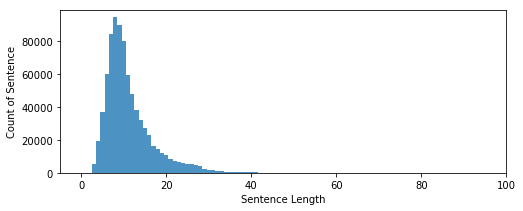

In [116]:
from collections import Counter

senLenDist = [len(w) for w in (question1_splitted + question2_splitted)]
l = Counter(senLenDist)
s = sorted(l.items(), key=lambda pair: pair[0])
plt.figure(figsize=(8, 3))
plt.bar([x[0] for x in s], [x[1] for x in s],align='center', alpha=0.8, width=1)

plt.xlim((-5, 100))
plt.xlabel("Sentence Length")
plt.ylabel("Count of Sentence")
# plt.title("Sentence length distribution")
# plt.tight_layout()
plt.savefig('data/fig/lengthdistribution.pdf')

# Transfer sentences into list of indexes with fixed length

In [22]:
max_length = 30
def sentToIndex(sent):
    sents_index = np.zeros( max_length)
    for i in range(min(max_length,len(sent))):
        sents_index[i] = words_index[sent[i]]
    return sents_index

In [23]:
q1_index = np.zeros((len(question1_lower),max_length))
q2_index = np.zeros((len(question2_lower),max_length))

for i,sent in enumerate(question1_lower):
    q1_index[i] = sentToIndex(sent)
    
for i,sent in enumerate(question2_lower):
    q2_index[i] = sentToIndex(sent)

print('shape of q1s {}'.format(q1_index.shape))
print('shape of q2s {}'.format(q2_index.shape))

shape of q1s (404288, 30)
shape of q2s (404288, 30)


In [28]:
acc = 0
for i in range(q1_index.shape[0]):
    union = np.union1d(q1_index[i], q2_index[i])
    intersection = np.intersect1d(q1_index[i], q2_index[i])
    iou = float(len(intersection))/len(union)
    if iou > 0.95:
        pred = 1
    else:
        pred = 0
    if pred == labels[i]:
        acc += 1
    

In [45]:
data_len = labels.shape[0]
float(acc)/data_len

0.6341791000474909

# Word Embedding (Glove)

In [33]:
embeddings_index = {}
f = open('data/glove/glove.840B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 2196016 word vectors.


In [34]:
embedding_matrix = np.zeros((len(words_index) + 1, 300))
unknown_words = []
for word, i in words_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.random.randn(1,300) * 0.25
        unknown_words.append(word)
print('Embedding Shape {}'.format(embedding_matrix.shape))
print('Number of unknown words = {}'.format(len(unknown_words)))

Embedding Shape (85542, 300)
Number of unknown words = 18682


In [35]:
print(unknown_words[10:50])

['carryminati', 'googlenet', 'emkit', 'jayakanthan', 'vologda', 'girokonto', 'cl20', 'starboy', 'arrowverse', 'krampusnacht', '300er', 'alchemyapi', 'naache', 'movietv', 'trivikram', 'lngedna', 'bhubaneshwar', 'erus', 't250si', 't250sl', 'massachisetts', 'tdv6', 'nictone', 'imporatnace', '\\sin\\frac', 'darkon', '80watts', 'vnit', 'pavlok', 'thranduil', 'gofundme', 'pgdhrm', 'cazpro', 'musil', 'unlearnable', 'twenty19', 'kayasthas', 'inorgnc', 'bluerock', 'borstar']


# Save all data

In [36]:
np.save(open('data/processed/q1_processed.npy', 'wb'), q1_index)
np.save(open('data/processed/q2_processed.npy', 'wb'), q2_index)

np.save(open('data/processed/label_processed.npy', 'wb'), labels)
np.save(open('data/processed/glove_word_embedding_matrix.npy', 'wb'), embedding_matrix)